<a href="https://colab.research.google.com/github/ekmungi/ml_examples/blob/master/cnn_pytorch_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imageio
!pip install torch torchvision

In [0]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os, tarfile
import imageio
from scipy.io import loadmat
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets



# Organize data

In [0]:
train_dataset = dsets.FashionMNIST(root='./data', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data', 
                                  train=False, 
                                  transform=transforms.ToTensor())

In [36]:
batch_size = 100
ITERATIONS = 3000
EPOCHS = 20#int(ITERATIONS / (len(train_dataset) / batch_size))
print("For a dataset of size {0} \nBatch size: {1} \nNumber of iterations: {2} \nNumber of epochs: {3}".format(len(train_dataset), batch_size, ITERATIONS, EPOCHS))

For a dataset of size 60000 
Batch size: 100 
Number of iterations: 3000 
Number of epochs: 20


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [6]:
(images, labels) = next(iter(train_loader))



for i, (images, labels) in enumerate(train_loader):
#     images = images.view(-1, 28, 28)
    print(images.shape, labels.shape)
    if i==10:
        break

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])


torch.Size([100, 1, 28, 28]) torch.Size([100])


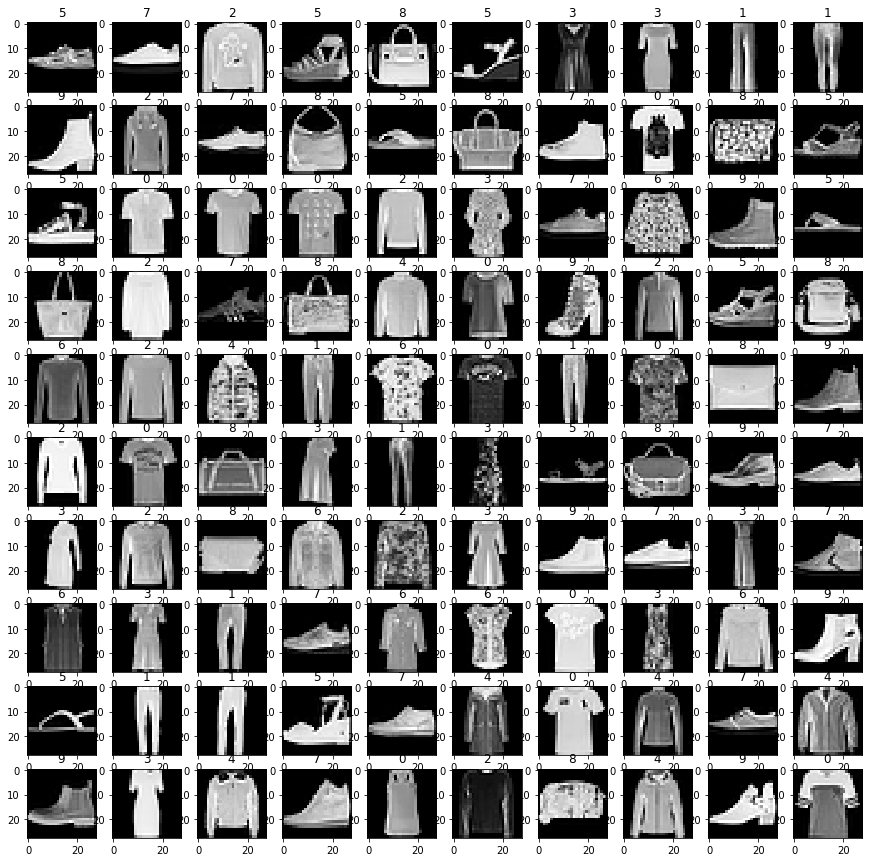

In [7]:
(images, labels) = next(iter(train_loader))
print(images.shape, labels.shape)

f, axarr = plt.subplots(10, 10, figsize=(15,15))
index = 0
for row in range(10):
    for col in range(10):
        axarr[row,col].imshow(np.squeeze(np.squeeze(images[index,0, :, :].numpy())), cmap='gray')
        axarr[row,col].set_title(str(labels[index].numpy()))
        index+=1

# Utility functions

#### ToDos
- Create a function to fetch data from a url.
- Check if it is already downloaded.
- Check if the file is csv or tar gz etc.
- Add cross-validation code to be able to use sklearn cross_val_score function to quickly evaluate the performance.

In [0]:
def one_hot_encoder(label):
    encoder = OneHotEncoder(dtype=np.float32, categories='auto')
    label_1hot = encoder.fit_transform(label.reshape(-1,1))
    print('The labels are: {}'.format(np.unique(label)))
    return label_1hot

# Load data

In [9]:
(images, labels) = next(iter(train_loader))
labels_1hot = one_hot_encoder(labels.numpy()).toarray().view(np.float32)
print(labels_1hot.shape)

The labels are: [0 1 2 3 4 5 6 7 8 9]
(100, 10)


# Model definition

In [0]:
class Classifier(nn.Module):
    def __init__(self, width, height, n_channels, n_classes):
        super(Classifier, self).__init__()

        self.width = width
        self.height = height
        self.channels = n_channels
        self.conv_1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
#         self.fc5 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.fc5 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.fc6 = nn.Linear(in_features=1024, out_features=n_classes)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.dropout2d = nn.Dropout2d(p=0.5)
    
    
    def forward(self, X):
    
        out = X.view(-1, self.channels, self.width, self.height)
        out = self.conv_1(out)
        out = self.dropout2d(out)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
#         print(out.size())
        out = self.maxpool(out)
#         print(out.size())
        out = self.conv_3(out)
        out = self.dropout2d(out)
        out = self.activation(out)
        out = self.conv_4(out)
        out = self.activation(out)
#         print(out.size())
        out = self.maxpool(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
        out = self.fc5(out)
        out = self.dropout(out)
        out = self.activation(out)
        out = self.fc6(out)
        
        return out
    
                    
#     def predict(self, X, n_batches, batch_size):
    
#         correct = 0
#         test_cost = 0
#         total = 0
#         first = True
#         for ibatch in range(n_batches):
#             X_batch = torch.from_numpy(X[ibatch*batch_size:(ibatch+1)*batch_size,:])

#             outputs = self.forward(X_batch)
#             if first == True:
#                 predicted = torch.argmax(outputs, dim=1)
#                 first = False
#             else:
#                 predicted = torch.cat((predicted, torch.argmax(outputs, dim=1)))
                
#         # Remaining images left in the batch
#         X_batch = torch.from_numpy(X[(ibatch+1)*batch_size:,:])
#         outputs = self.forward(X_batch)
#         predicted = torch.cat((predicted, torch.argmax(outputs, dim=1)))

#         return predicted
    
#     def score(self, Y, predicted):
    
#         #predicted = torch.argmax(predicted, axis=1)
#         accuracy = 100*(Y == predicted.data.numpy()).sum()/Y.shape[0]
#         return accuracy
        

In [0]:
model = Classifier(28, 28, 1, 10)
if torch.cuda.is_available():
    model.cuda()

In [0]:
# tmp = torch.randn(100, 1, 28, 28)
# out = model(tmp)
# print(out.shape)

In [0]:
LEARNING_RATE = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [40]:
# def fit(self, X, Y, criterion, optimizer, epochs, n_batches, batch_size, print_time, X_test=None, Y_test=None):
loss_list = []
for epoch in range(EPOCHS):
    
    for iteration, (X, y) in enumerate(train_loader):
        
#         y_1hot = torch.from_numpy(one_hot_encoder(y.numpy()).toarray().view(np.float32))
        
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
#             y_1hot = y_1hot.cuda()            
        

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        if iteration%100 == 0:
            with torch.no_grad():
                loss_list.append(loss.detach().cpu().numpy())
                print("[{0}/{1}] : {2}".format(epoch, iteration, loss.detach().cpu().numpy()))
#             if X_test is not None:
#                 predictions = self.predict(X_test, X_test.shape[0]//batch_size, batch_size)
#                 accuracy = np.round(self.score(Y_test, predictions), 2)
#                 print('Epoch: {}, Iteration: {}, Loss: {}, Test accuracy: {}%'.format(epoch, iteration, loss, accuracy))
#             else:
#                 print('Epoch: {}, Iteration: {}, Loss: {}'.format(epoch, iteration, loss))
#             #accuracy = predict(test_loader)

[0/0] : 2.3005809783935547
[0/100] : 1.0688276290893555
[0/200] : 0.918668270111084
[0/300] : 0.7686820030212402
[0/400] : 0.7792796492576599
[0/500] : 0.5749466419219971
[1/0] : 0.5686300992965698
[1/100] : 0.6732887029647827
[1/200] : 0.7175529599189758
[1/300] : 0.436798632144928
[1/400] : 0.5927221775054932
[1/500] : 0.3939618766307831
[2/0] : 0.4726032316684723
[2/100] : 0.348552405834198
[2/200] : 0.5291379690170288
[2/300] : 0.42787909507751465
[2/400] : 0.4737814664840698
[2/500] : 0.5610746741294861
[3/0] : 0.42517292499542236
[3/100] : 0.5153301954269409
[3/200] : 0.310011088848114
[3/300] : 0.3611851930618286
[3/400] : 0.39694663882255554
[3/500] : 0.5789330005645752
[4/0] : 0.37441644072532654
[4/100] : 0.3275902569293976
[4/200] : 0.5026548504829407
[4/300] : 0.4418741464614868
[4/400] : 0.32963109016418457
[4/500] : 0.4467054307460785
[5/0] : 0.4479335844516754
[5/100] : 0.40698719024658203
[5/200] : 0.43711429834365845
[5/300] : 0.45521679520606995
[5/400] : 0.4149045050

Text(0.5, 0, 'Step')

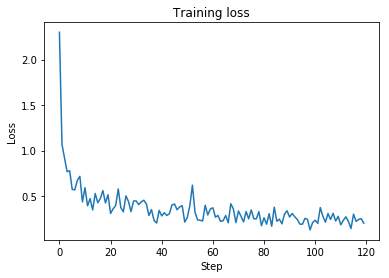

In [41]:
plt.plot(range(len(loss_list)), loss_list)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Step")